# Модели машинного обучения различной архитектуры: сравнение на реальных данных

И снова здравствуйте, ~~новоземельские белые медведи~~ польские бобры. 

Будем решать задачу аппроксимации турбулентных потоков тепла над городскими ландшафтами. 

Используются данные международного проекта [Urban Plumber](https://urban-plumber.github.io/) для точки [PL-Lipova](https://urban-plumber.github.io/PL-Lipowa/) в городе Лодзь. 

Статья про данные: [Lipson et al. (2022, ESSD) Harmonized gap-filled datasets from 20 urban flux tower sites](https://doi.org/10.5194/essd-14-5157-2022)


In [2]:
import os, sys
import pickle as pkl
import xarray as xr
import pandas as pd 
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge   
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostRegressor



def memorysize (obj):
    with open('temp.pkl', 'wb') as f:
        pkl.dump(obj, f)
    size = os.path.getsize('temp.pkl')
    os.remove('temp.pkl')
    return size


In [3]:
ds = xr.open_dataset ("data4model_comparison/PL-Lipowa_raw_observations_v1.nc")

df = ds.to_dataframe()
df = df.drop(columns = [c for c in df.columns if "_qc" in c])
display(df.head())
display(df.describe())

#df.resample('3H').mean()
df_smoothed = df.groupby(pd.Grouper(freq='3h', closed='left', label='left', convention='start')).mean()


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
time,,,,,,,,,,,,,
2008-01-01 00:00:00,-0.05,338.130005,273.040009,0.003802,99700.0,0.0,NaN,-0.255,1.437,0.00,343.760010,97.680000,-1.869
2008-01-01 01:00:00,0.00,339.160004,272.980011,0.003783,99700.0,0.0,NaN,-0.333,1.501,0.00,343.510010,-11.725000,3.217
2008-01-01 02:00:00,0.00,337.899994,272.959991,0.003777,99700.0,0.0,NaN,-0.206,1.328,0.00,343.609985,26.704000,0.219
2008-01-01 03:00:00,0.00,338.149994,272.920013,0.003765,99700.0,0.0,NaN,0.188,0.792,0.45,343.410004,-5.829000,0.352
2008-01-01 04:00:00,0.01,338.839996,272.910004,0.003762,99700.0,0.0,NaN,0.455,1.039,0.60,343.209991,41.268002,-1.121


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Snowf,Wind_N,Wind_E,SWup,LWup,Qle,Qh
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,0.0,38455.000000,38455.000000,40369.000000,40369.000000,29193.000000,29196.000000
mean,123.889549,344.117676,282.331848,0.006654,98924.929688,0.000015,NaN,0.263691,0.468939,13.019703,399.141083,20.190529,34.463863
std,205.480896,50.961803,8.913330,0.003236,852.744202,0.000119,NaN,2.423843,2.431707,18.432878,59.382599,32.610863,66.810616
min,-6.760000,170.149994,254.410004,0.000605,95250.000000,0.000000,NaN,-10.531000,-8.752000,-4.230000,255.740005,-98.999001,-98.473999
25%,-0.730000,312.527496,275.899994,0.004191,98400.000000,0.000000,NaN,-1.394000,-1.299000,1.370000,353.779999,2.950000,-5.444500
50%,4.900000,346.510010,282.489990,0.006156,98980.000000,0.000000,NaN,0.187000,0.675000,2.740000,391.700012,11.523000,9.251500
75%,166.372501,379.609985,289.230011,0.008769,99450.000000,0.000000,NaN,2.130000,2.121000,19.600000,439.359985,29.500999,49.053749
max,955.809998,493.380005,307.149994,0.018955,101720.000000,0.007722,NaN,10.599000,9.964000,214.699997,616.409973,317.648010,482.760010


In [4]:
%matplotlib qt
df['Qh'].plot()
df_smoothed['Qh'].plot()

<Axes: xlabel='time'>

In [6]:
df4ml = df_smoothed.drop (columns=['Snowf', 'SWup'])
df4ml = df4ml.dropna()
df4ml = df4ml.sample(1000)

df4ml['Wind_vel'] = np.sqrt (df4ml['Wind_N']**2 + df4ml['Wind_E']**2)
sigma = 5.67*(10**-8)

df4ml['Ts'] = (df4ml['LWup'] / sigma) **0.25 - 273.15
df4ml['delta_T'] = df4ml['Ts'] - df4ml['Tair']
df4ml = df4ml.drop (columns=['LWup'])

display(df4ml.describe())


,SWdown,LWdown,Tair,Qair,PSurf,Rainf,Wind_N,Wind_E,Qle,Qh,Wind_vel,Ts,delta_T
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,133.553482,345.419250,282.801178,0.006656,98949.101562,0.000008,0.230216,0.453610,19.757328,33.863728,3.026883,16.817770,-265.983429
std,205.948563,51.050423,9.098638,0.003304,802.518372,0.000047,2.357878,2.302147,28.262745,63.292084,1.395459,11.136596,2.873791
min,-3.346667,188.673340,256.253326,0.000613,96033.335938,0.000000,-7.042667,-6.751667,-80.170998,-73.747673,0.151068,-11.981842,-270.838196
25%,-0.395000,309.940002,276.162491,0.004059,98439.166016,0.000000,-1.312750,-1.320667,3.326084,-3.794667,2.075091,8.509323,-267.907585
50%,17.025001,346.059998,283.291672,0.006030,99000.000000,0.000000,0.141833,0.595500,12.135916,10.298667,2.871258,16.471130,-266.806305
75%,199.986664,383.514153,289.857491,0.008909,99476.664062,0.000000,2.056167,2.155750,29.905249,47.226126,3.762021,24.853378,-265.029770
max,841.409973,460.163330,305.953339,0.017162,101400.000000,0.000620,6.305334,7.627333,149.470001,370.880493,9.566338,45.906281,-254.666779


<Axes: >

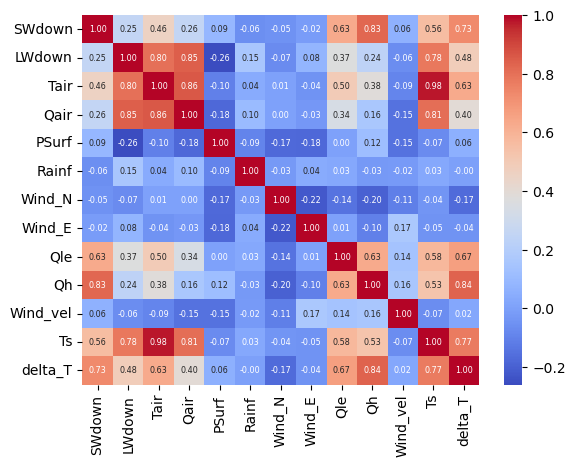

In [7]:
%matplotlib inline
sns.heatmap (df4ml.corr(), annot=True, cmap="coolwarm", fmt=".2f", annot_kws={'size': 'xx-small'})

In [9]:
class BootstrapCV:
    
    def __init__(self, n_splits, sample_size, random_state = 42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.sample_size = sample_size

    def split(self, X, y=None, groups=None):
        np.random.seed (self.random_state)
        for i in range(self.n_splits):
            sample_indices = np.random.randint(0,X.shape[0], self.sample_size)
            oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
            yield sample_indices, oob_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [32]:
target = 'Qle'
X = df4ml.drop (columns=['Qh', 'Qle'])
Y = df4ml[target]

models = [LinearRegression (), 
          KNeighborsRegressor (),
          DecisionTreeRegressor (max_depth=20),
          #RandomForestRegressor (),
          #GradientBoostingRegressor (), 
          GradientBoostingRegressor (learning_rate = 0.03603075049685412, max_depth = 3, n_estimators = 84)] 

#cv = KFold(n_splits=10)
cv = BootstrapCV (n_splits=20, sample_size=int (Y.shape[0]*0.95), random_state = 42)

scores = {}

use_scaler = False

for model in tqdm(models):

    model_pp = Pipeline([
                        ('scaler', StandardScaler(with_mean=use_scaler, with_std=use_scaler)),
                        ('regressor', TransformedTargetRegressor(regressor=model, transformer=StandardScaler(with_mean=use_scaler, with_std=use_scaler)))
                        ])

    scores4model = cross_validate(model_pp, X, Y, cv=cv, n_jobs=8,
                                  scoring=['r2', 'neg_root_mean_squared_error'], return_train_score = True, return_estimator=True, return_indices=True)

    scores4model['train_idx'] = scores4model['indices']['train']
    scores4model['test_idx'] = scores4model['indices']['test']
    scores4model.pop('indices')
    
    scores4model['model'] = model.__class__.__name__
    scores[model.__class__.__name__] = scores4model


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


In [33]:
scores_df = pd.concat ([pd.DataFrame(scores[model]) for model in scores.keys()], ignore_index=True)

scores_df['test_rmse'] = -scores_df['test_neg_root_mean_squared_error']
scores_df['train_rmse'] = -scores_df['train_neg_root_mean_squared_error']

#scores_df['estimator_memsize'] = [sys.getsizeof(estimator['regressor']) for estimator in scores_df['estimator']]
scores_df['estimator_memsize'] = [memorysize(estimator['regressor']) for estimator in scores_df['estimator']]
scores_df.head()



,fit_time,score_time,estimator,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,train_idx,test_idx,model,test_rmse,train_rmse,estimator_memsize
0,0.005493,0.004530,"(StandardScaler(with_mean=False, with_std=Fals...",0.548673,0.452160,-19.253143,-20.569050,"[102, 435, 860, 270, 106, 71, 700, 20, 614, 12...","[2, 3, 5, 6, 7, 9, 10, 12, 23, 25, 29, 30, 31,...",LinearRegression,19.253143,20.569050,997
1,0.005497,0.002521,"(StandardScaler(with_mean=False, with_std=Fals...",0.442392,0.532718,-19.855816,-20.096754,"[783, 967, 357, 971, 407, 667, 372, 7, 121, 34...","[1, 8, 11, 13, 15, 19, 20, 21, 23, 29, 30, 32,...",LinearRegression,19.855816,20.096754,997
2,0.006020,0.002999,"(StandardScaler(with_mean=False, with_std=Fals...",0.458903,0.567592,-21.927799,-17.474535,"[147, 466, 738, 243, 490, 848, 957, 506, 364, ...","[3, 4, 5, 12, 14, 17, 18, 22, 25, 29, 31, 33, ...",LinearRegression,21.927799,17.474535,997
3,0.007031,0.002986,"(StandardScaler(with_mean=False, with_std=Fals...",0.479873,0.537642,-21.787596,-18.293585,"[219, 961, 703, 965, 574, 584, 160, 680, 88, 6...","[0, 3, 4, 5, 8, 10, 14, 15, 17, 21, 23, 26, 27...",LinearRegression,21.787596,18.293585,997
4,0.008029,0.003495,"(StandardScaler(with_mean=False, with_std=Fals...",0.515169,0.505609,-19.589352,-20.564745,"[480, 145, 830, 627, 112, 762, 475, 762, 302, ...","[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 16, ...",LinearRegression,19.589352,20.564745,997


## Считаем заново прогнозные значения целевой переменной для тестовой и тренировочной выборок 

Это нужно, так как сross_validate их не возвращает, а мы хотим построить диаграмму рассеяния. Записываем их в один большой DataFrame.

In [34]:
reg_results = []

for i in scores_df.index:
    train_idx = scores_df.loc[i, 'train_idx']
    test_idx =  scores_df.loc[i, 'test_idx']
    
    cur_Y_train = Y.iloc[train_idx]
    cur_Y_test  = Y.iloc[test_idx]

    cur_X_train = X.iloc[train_idx]
    cur_X_test  = X.iloc[test_idx]

    cur_Y_train_pred = scores_df.loc[i, 'estimator'].predict(cur_X_train)
    cur_Y_test_pred  = scores_df.loc[i, 'estimator'].predict(cur_X_test)
    
    reg_results.append (pd.DataFrame({'Y':cur_Y_train, 'Y_pred':cur_Y_train_pred, 'model': scores_df.loc[i,'model'], 'type': 'train'}))
    reg_results.append (pd.DataFrame({'Y':cur_Y_test,  'Y_pred':cur_Y_test_pred,  'model': scores_df.loc[i,'model'], 'type': 'test'}))
    
reg_results = pd.concat(reg_results)

## Строим диаграммы рассеяния для разных моделей и выборок (train/test)

<Figure size 640x480 with 0 Axes>

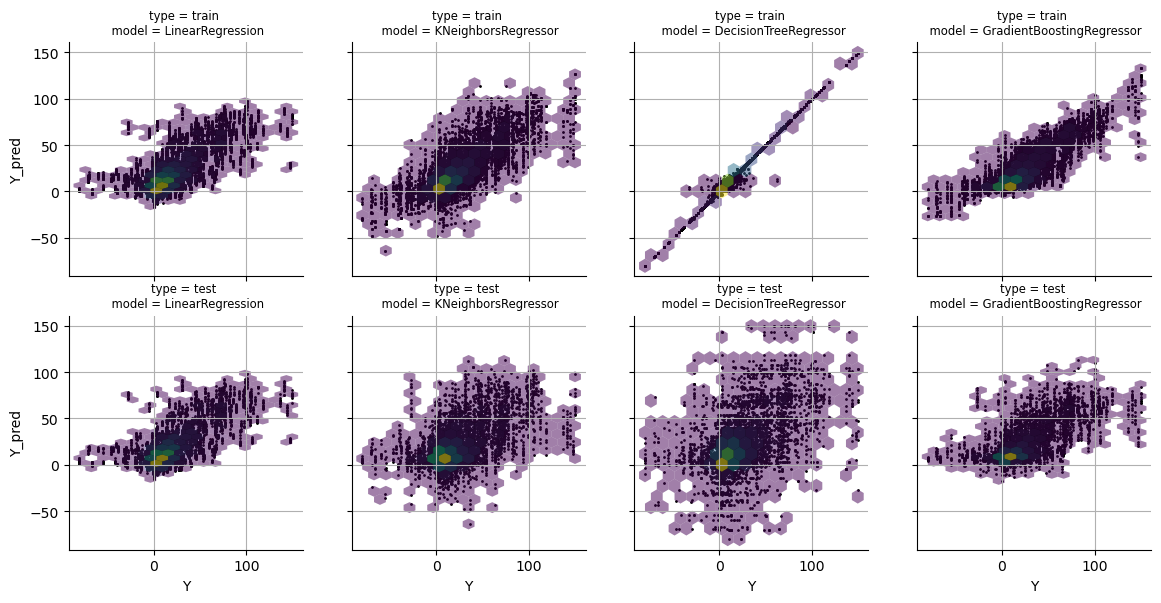

In [35]:
def myhexbin(*args, **kwargs):
        kwargs.pop("color", None)
        hb = plt.hexbin(*args, **kwargs)
        return hb

plt.figure()
g = sns.FacetGrid (reg_results, col = 'model', row='type')
g.map(plt.scatter, 'Y', 'Y_pred', s=1, color = 'black') 
g.map(myhexbin, 'Y', 'Y_pred', mincnt=1, gridsize=18, alpha = 0.5, edgecolor = None) 

for ax in g.axes.flatten():
        ax.set_title(ax.title.get_text().replace('|', '\n'), fontsize='small')
        ax.set_aspect(1) #'equal')
        ax.grid(zorder=0)



## Посмотрим на метрики качества и их неопределенность для разных bootstrap-выборок. 

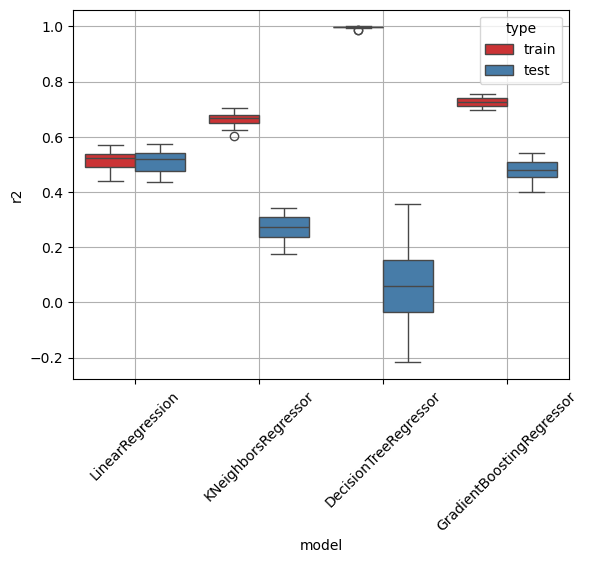

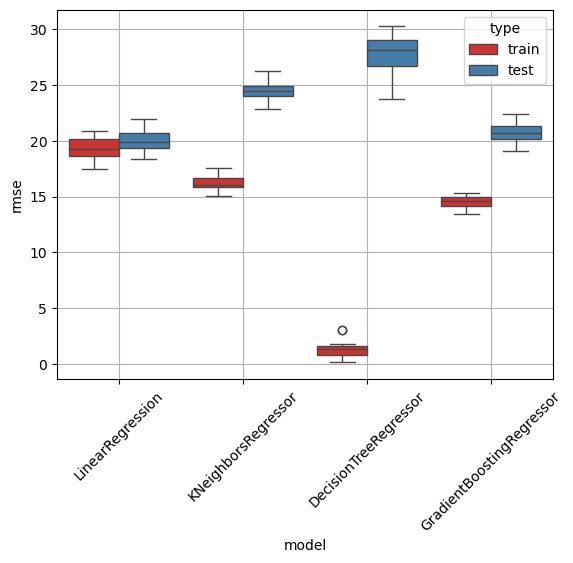

In [36]:

for metric in ['r2', 'rmse']:
    df1 = scores_df[['model', 'train_' + metric]].rename(columns={'train_' + metric: metric,})
    df2 = scores_df[['model', 'test_' + metric]].rename(columns={'test_' + metric: metric,})

    df1['type'] = 'train'
    df2['type'] = 'test'
    df2boxplot = pd.concat([df1, df2])

    plt.figure()
    sns.boxplot (df2boxplot, x='model', y=metric, hue='type', palette='Set1')
    _ = plt.xticks(rotation=45)
    plt.grid()



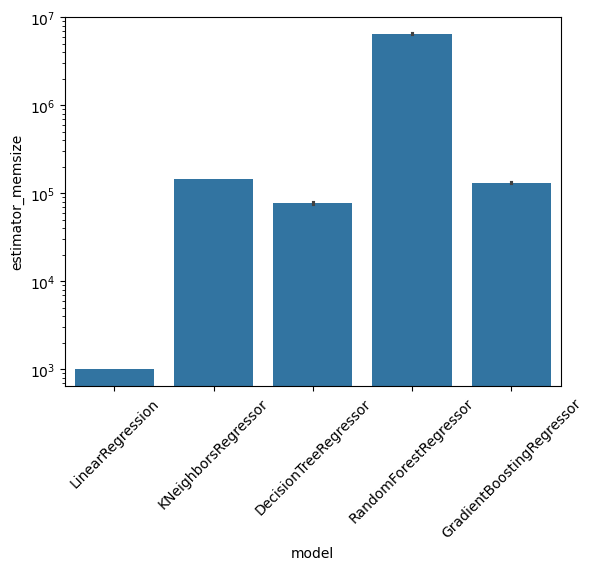

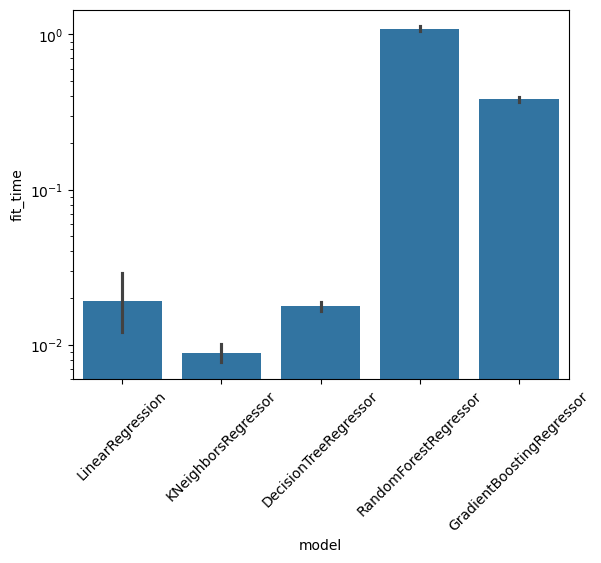

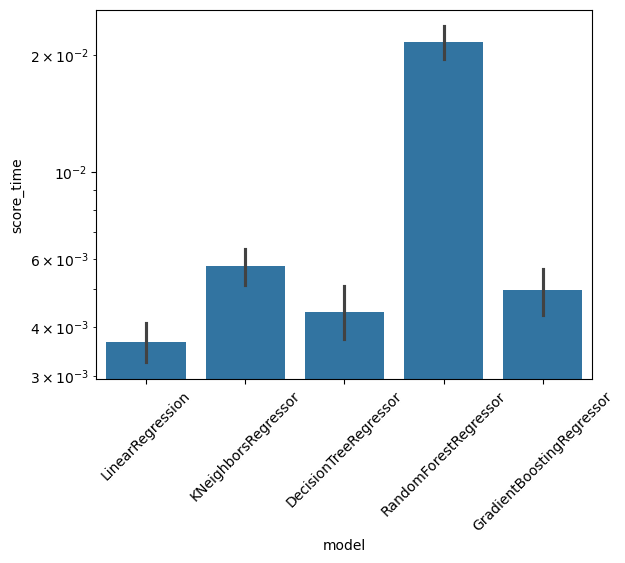

In [20]:
plt.figure()
sns.barplot (scores_df, x='model', y='estimator_memsize')
plt.xticks(rotation=45)
plt.yscale('log')

plt.figure()
sns.barplot (scores_df, x='model', y='fit_time')
plt.xticks(rotation=45)
plt.yscale('log')

plt.figure()
sns.barplot (scores_df, x='model', y='score_time')
plt.xticks(rotation=45)
plt.yscale('log')

## Оптимизация гиперпараметров методом GridSearch

In [24]:
cv = BootstrapCV (n_splits=10, sample_size=int (Y.shape[0]*0.95), random_state = 42)

#model = KNeighborsRegressor()
#parameters = {'n_neighbors': [1, 2, 3, 5, 10, 20, 50, 100, 200]}

model = GradientBoostingRegressor()
parameters = {'n_estimators': [20, 50, 100, 200], 'max_depth': [2, 3, 5, 10], 'learning_rate': [0.01, 0.1, 0.2]}

clf = GridSearchCV(model, parameters, cv = cv, n_jobs=8, scoring = 'neg_root_mean_squared_error')
clf.fit(X, Y)

GridSearchCV(cv=<__main__.BootstrapCV object at 0x000001C60B4E64B0>,
             estimator=GradientBoostingRegressor(), n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 5, 10],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [25]:
display (clf.best_params_)
display (clf.cv_results_['mean_test_score'])
#clf.cv_results_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

array([-26.93007152, -24.75748067, -22.67037707, -21.13428369,
       -26.77314135, -24.47801918, -22.38874245, -21.01757302,
       -26.65193668, -24.3653903 , -22.45530171, -21.31004509,
       -26.69296743, -24.64140883, -23.30428871, -22.95508092,
       -21.08586994, -20.75456786, -20.98564455, -21.29434764,
       -20.99309743, -20.92419033, -21.25092957, -21.65045326,
       -21.28203071, -21.26186438, -21.49373121, -21.60424099,
       -23.02933534, -23.1592863 , -23.24697911, -23.25689877,
       -20.78332773, -21.08273328, -21.40182171, -21.80839866,
       -21.02991858, -21.45943736, -21.87520693, -22.19753378,
       -21.44554168, -21.76619981, -21.93648302, -22.0229851 ,
       -23.15070268, -23.12125003, -23.23318779, -23.29043495])

## Баесова оптимизация с использованием фреймворка Optuna 

In [27]:
import optuna
from optuna.samplers import TPESampler

# Define the objective function
def objective (trial):
    
    # n_neighbors = trial.suggest_int('n_neighbors', 1, 200)
    # weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    # model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 20, 200)
    model = GradientBoostingRegressor(learning_rate = learning_rate, max_depth = max_depth, n_estimators = n_estimators)
    #model = CatBoostRegressor(learning_rate = learning_rate, max_depth = max_depth, n_estimators = n_estimators, silent=True)
    
    cv = BootstrapCV (n_splits=5, sample_size=int (Y.shape[0]*0.95), random_state = 42)
    scores = cross_val_score(model, X, Y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# Run the optimization
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)

[I 2024-12-03 11:53:31,600] A new study created in memory with name: no-name-2e81897c-31fe-4f98-a665-6911e3d5d0ae
[I 2024-12-03 11:53:32,347] Trial 0 finished with value: 23.05228268121819 and parameters: {'learning_rate': 0.20887606396846303, 'max_depth': 9, 'n_estimators': 21}. Best is trial 0 with value: 23.05228268121819.
[I 2024-12-03 11:53:35,456] Trial 1 finished with value: 22.199480157520373 and parameters: {'learning_rate': 0.048057749440215354, 'max_depth': 7, 'n_estimators': 118}. Best is trial 1 with value: 22.199480157520373.
[I 2024-12-03 11:53:36,901] Trial 2 finished with value: 22.814351672066863 and parameters: {'learning_rate': 0.03194443159281955, 'max_depth': 10, 'n_estimators': 42}. Best is trial 1 with value: 22.199480157520373.
[I 2024-12-03 11:53:42,610] Trial 3 finished with value: 23.290107220574058 and parameters: {'learning_rate': 0.4090493798923961, 'max_depth': 9, 'n_estimators': 190}. Best is trial 1 with value: 22.199480157520373.
[I 2024-12-03 11:53:4

Best hyperparameters: {'learning_rate': 0.03603075049685412, 'max_depth': 3, 'n_estimators': 84}
Best score: 20.494129412753242


In [ ]:
# from plotly.io import show
# fig = optuna.visualization.plot_contour(study, params=["learning_rate", "max_depth"])
# show(fig)